# Let's Explore Some Telco Churn Data

Data can be found here WA_Fn-UseC_-Telco-Customer-Churn.csv: https://community.watsonanalytics.com/wp-content/uploads/2015/03/WA_Fn-UseC_-Telco-Customer-Churn.csv

# What’s in the Telco Customer Churn data set?
This data set provides info to help you predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs.

A telecommunications company is concerned about the number of customers leaving their landline business for cable competitors. They need to understand who is leaving. Imagine that you’re an analyst at this company and you have to find out who is leaving and why.

The data set includes information about:
* Customers who left within the last month – the column is called Churn
* Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
* Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
* Demographic info about customers – gender, age range, and if they have partners and dependents

# If you don’t have the data set…
Go to https://community.watsonanalytics.com/resources/
* Download the Telco Customer Churn sample data file.
* In Watson Analytics, tap Add and upload Telco Customer Churn.
* The filename is a bit longer: WA_Fn-UseC_-Telco-Customer-Churn.csv.


# Choose interactive or inline plotting

In [1]:
#%matplotlib notebook
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np

churn = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
#churn.info()



# Handy Utilities

In [3]:
from itertools import compress
class MaskableList(list):
    def __getitem__(self, index):
        try: return super(MaskableList, self).__getitem__(index)
        except TypeError: return MaskableList(compress(self, index))
        
def DescribeItemRange(df):  # Show the number of unique values in each column
    cols = df.columns.tolist()
    vals = pd.DataFrame ( [ len(set(df[s])) for s in df.columns.tolist()] ).T
    vals.columns = cols
    return vals

def ReplaceNans (df):  #replace NaNs in all df locations with zeros
    df.fillna(0)
    return df

def SelectZeroColumns (df): #return a list with column names of zero filled columns
    dropcols = (df == 0).all().astype(int).tolist()
    return [s for s in mylist[dropcols]  ]

def SelectNonZeroColumns(df):  #return a list with columns names of nonzero columns
    return list(set(StringifyColumnNames(df))- set(SelectZeroColumns(df) ))

def StringifyColumnNames (df):   # handle unicode strings and covert to normal strings
    cols = df.columns.tolist()
    cols = [str(r) for r in cols]
    return cols

def Factorize(df):
    return  df.apply(lambda x: pd.factorize(x)[0])

def MyOneHotEncode(pdold, StaticCols, EncodeCols):
    """MyOneHotEncode performs OneHotEncoding on specified columns in our dataframe"""
    """pdold is the old dataframe we are paasing in"""
    """StaticCols is a list of columns we do not wish to encode"""
    """EncodeCols is a list of columns we wish to encode"""
    # make sure that we our static list is not in our encode list
    cols_OneHotEncode = sorted(list(set(EncodeCols) - set(StaticCols)))
    # create a new dataframe which represents the static columns
    pdnew = pdold[StaticCols]
    # loop thru the endcode list and OneHotEncode (using get_dummies) each column in the encode list
    # note - this will typically map a single column to several columns - one for each value contained in the original column
    for col in cols_OneHotEncode:
        new_names = []
        enc = pd.get_dummies(pdold[col])
        for subcol in  enc:
            name = col + str(subcol)
            new_names.append(name)
        enc.columns = new_names
        # concat the new OneHotEnoded dataframe to the original
        pdnew = pd.concat([pdnew, enc], axis=1)
    return pdnew


def my_dbscan(df, eps_):
# Compute DBSCAN
    labels = []
    db = DBSCAN(eps=eps_, min_samples=100).fit(df)
    labels = pd.DataFrame(db.labels_ )
    #n_clusters_ = labels[0].madf()
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    # Number of clusters in labels, ignoring noise if present.
    #tdft = 'dbsPCA_' + str(n_clusters_)
    tdft = 'dbsPCA'
    df[tdft]=labels
    print('eps:{} Estimated number of clusters: {}'.format(eps_, n_clusters_) ) 
    return df, labels, n_clusters_


# Some Cleaning Required
TotalCharges is an object rather than a float64. We will convert it to float64 and **force any non numeric items** to be repalced with the **mean**.

In [4]:
churn[['TotalCharges']] = churn[['TotalCharges']].apply(pd.to_numeric, errors='coerce') 
churn["TotalCharges"].fillna(churn["TotalCharges"].mean(), inplace=True)

# Describe the Range of Values in each Column

In [5]:
DescribeItemRange(churn)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7043,2,2,2,2,73,2,3,3,3,...,3,3,3,3,3,2,4,1585,6531,2


## Explore Churn Data
* the number of rows, 
* the number of columns,
* any descriptive statistics

## Separate Categorical from Numeric Data for Further Processing
* numeric data for now will be kept in a separate dataframe
* categorical data will be in its own dataframe for be transformed into values in kind of pipeline

In [6]:
# here are the columns which are categorical
churn_cat_col = [key for key in dict(churn.dtypes) if dict(churn.dtypes)[key] in ['object']]
# here are the columns which are numeric
churn_num_col = [key for key in dict(churn.dtypes) if dict(churn.dtypes)[key] in ['float64', 'int64']]
#create a dataframe to hold categorical data
churn_cat = churn[churn_cat_col]
#create a dataframe to hold numeric data
churn_num = churn[churn_num_col]
# display first few rows of numerical data to get a feel for them
print churn_num.head()
# display first few rows of categorical data to get a feel for them
churn_cat.head()

   SeniorCitizen  MonthlyCharges  tenure  TotalCharges
0              0           29.85       1         29.85
1              0           56.95      34       1889.50
2              0           53.85       2        108.15
3              0           42.30      45       1840.75
4              0           70.70       2        151.65


,Churn,DeviceProtection,TechSupport,OnlineBackup,MultipleLines,gender,StreamingTV,Contract,StreamingMovies,PhoneService,PaperlessBilling,OnlineSecurity,Partner,Dependents,InternetService,PaymentMethod,customerID
0,No,No,No,Yes,No phone service,Female,No,Month-to-month,No,No,Yes,No,Yes,No,DSL,Electronic check,7590-VHVEG
1,No,Yes,No,No,No,Male,No,One year,No,Yes,No,Yes,No,No,DSL,Mailed check,5575-GNVDE
2,Yes,No,No,Yes,No,Male,No,Month-to-month,No,Yes,Yes,Yes,No,No,DSL,Mailed check,3668-QPYBK
3,No,Yes,Yes,No,No phone service,Male,No,One year,No,No,No,Yes,No,No,DSL,Bank transfer (automatic),7795-CFOCW
4,Yes,No,No,No,No,Female,No,Month-to-month,No,Yes,Yes,No,No,No,Fiber optic,Electronic check,9237-HQITU


# Convert Categories to Numbers

we apply the factorize fucntion to all the categories as a first pass. We created a new dataframe here called **churn_cat_encode**

The commented out code woudl allow us to map back to the original form if needed

PaymentMethod for example will now have numeric values like 0, 1, 2, 3,...:


In [7]:
#  Factorize the categorical churn columns
churn_cat_encode = Factorize(churn_cat)
churn_cat_encode.head()

,Churn,DeviceProtection,TechSupport,OnlineBackup,MultipleLines,gender,StreamingTV,Contract,StreamingMovies,PhoneService,PaperlessBilling,OnlineSecurity,Partner,Dependents,InternetService,PaymentMethod,customerID
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,1,1,0,1,0,1,1,1,1,0,0,1,1
2,1,0,0,0,1,1,0,0,0,1,0,1,1,0,0,1,2
3,0,1,1,1,0,1,0,1,0,0,1,1,1,0,0,2,3
4,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,4


# Encode the data (OneHotEncode)
The problem with the data above is that while the data are numeric, it give arbitrary low weights to categories encoded with 0 and higher weights to others

This will probably skew our analysis. For example, PaymentMethod has values 0, 1, 2.  Do we really mean to imply that PaymentMethod=0 has no weight, but PaymentMethod=2 has twice as much weight as PaymentMethod=1?

We use OneHotEncode here to make sure each value that was used is encoded with the value 1, while the value will be 0 if that feature was not used.

**Note:** We dont want to encode categories with many unique values in it such as customerID. 

We define a funvtion to handle doing the encoding for us

Now PaymentMethod will be split into brand new columns (one for each kind of numeric value) and each cell will have either 0 or 1, kind of like a check box, indicating the feature was present or not.

We also concatenate the previous numerica columns back in to have them available for analysis after standardization.

In [8]:
# list of column name I wish to OneHotEncode
cols_OneHotEncode = ['DeviceProtection','TechSupport','OnlineBackup','MultipleLines','gender','StreamingTV','Contract','StreamingMovies','PhoneService','PaperlessBilling','OnlineSecurity','Partner','Dependents','InternetService','PaymentMethod']
# label is the column I ultimately want to predict aka Churn
label = churn_cat_encode['Churn']
# customer is the column representing the customerId
customer =  churn_cat_encode['customerID']
churn_encoded_numeric = MyOneHotEncode (churn_cat_encode, [], cols_OneHotEncode)
churn_encoded_numeric = pd.concat([churn_encoded_numeric, churn_num], axis=1)  # add numeric to main df
churn_encoded_numeric.head()

,Contract0,Contract1,Contract2,Dependents0,Dependents1,DeviceProtection0,DeviceProtection1,DeviceProtection2,InternetService0,InternetService1,...,StreamingTV2,TechSupport0,TechSupport1,TechSupport2,gender0,gender1,SeniorCitizen,MonthlyCharges,tenure,TotalCharges
0,1,0,0,1,0,1,0,0,1,0,...,0,1,0,0,1,0,0,29.85,1,29.85
1,0,1,0,1,0,0,1,0,1,0,...,0,1,0,0,0,1,0,56.95,34,1889.50
2,1,0,0,1,0,1,0,0,1,0,...,0,1,0,0,0,1,0,53.85,2,108.15
3,0,1,0,1,0,0,1,0,1,0,...,0,0,1,0,0,1,0,42.30,45,1840.75
4,1,0,0,1,0,1,0,0,0,1,...,0,1,0,0,1,0,0,70.70,2,151.65


# Standardize the Data

In [9]:
from sklearn import preprocessing
#scale our data to zero center it
scaler = preprocessing.StandardScaler().fit(churn_encoded_numeric)
X_scaled = preprocessing.scale(churn_encoded_numeric, with_mean=True, with_std=True )   # same as (df-df.mean())/df.std(ddof=0)

# create new data frame with all values scaled
churn_scaled = pd.DataFrame(X_scaled)
churn_scaled.columns = churn_encoded_numeric.columns
churn_scaled.head()

,Contract0,Contract1,Contract2,Dependents0,Dependents1,DeviceProtection0,DeviceProtection1,DeviceProtection2,InternetService0,InternetService1,...,StreamingTV2,TechSupport0,TechSupport1,TechSupport2,gender0,gender1,SeniorCitizen,MonthlyCharges,tenure,TotalCharges
0,0.904184,-0.514249,-0.562975,0.654012,-0.654012,1.129427,-0.723968,-0.525927,1.381712,-0.885660,...,-0.525927,1.013869,-0.639439,-0.525927,1.009559,-1.009559,-0.439916,-1.160323,-1.277445,-0.994971
1,-1.105970,1.944582,-0.562975,0.654012,-0.654012,-0.885405,1.381277,-0.525927,1.381712,-0.885660,...,-0.525927,1.013869,-0.639439,-0.525927,-0.990532,0.990532,-0.439916,-0.259629,0.066327,-0.173876
2,0.904184,-0.514249,-0.562975,0.654012,-0.654012,1.129427,-0.723968,-0.525927,1.381712,-0.885660,...,-0.525927,1.013869,-0.639439,-0.525927,-0.990532,0.990532,-0.439916,-0.362660,-1.236724,-0.960399
3,-1.105970,1.944582,-0.562975,0.654012,-0.654012,-0.885405,1.381277,-0.525927,1.381712,-0.885660,...,-0.525927,-0.986321,1.563872,-0.525927,-0.990532,0.990532,-0.439916,-0.746535,0.514251,-0.195400
4,0.904184,-0.514249,-0.562975,0.654012,-0.654012,1.129427,-0.723968,-0.525927,-0.723740,1.129102,...,-0.525927,1.013869,-0.639439,-0.525927,1.009559,-1.009559,-0.439916,0.197365,-1.236724,-0.941193


## Copy Churn Column to Encoded Dataframe
This dataframe has the same number of rows as the principal components Dataframe

They are parallel with each other

This copy step may be redundant since we copied Churn to the PCA Dataframe too, but it makes plotting more convenient

In [10]:
if 'Churn' not in churn_encoded_numeric.columns:
    churn_encoded_numeric = pd.concat([churn_encoded_numeric, label], axis=1)
if 'Churn' not in churn_scaled.columns:
    churn_scaled = pd.concat([churn_scaled, label], axis=1)
churn_scaled.head()

,Contract0,Contract1,Contract2,Dependents0,Dependents1,DeviceProtection0,DeviceProtection1,DeviceProtection2,InternetService0,InternetService1,...,TechSupport0,TechSupport1,TechSupport2,gender0,gender1,SeniorCitizen,MonthlyCharges,tenure,TotalCharges,Churn
0,0.904184,-0.514249,-0.562975,0.654012,-0.654012,1.129427,-0.723968,-0.525927,1.381712,-0.885660,...,1.013869,-0.639439,-0.525927,1.009559,-1.009559,-0.439916,-1.160323,-1.277445,-0.994971,0
1,-1.105970,1.944582,-0.562975,0.654012,-0.654012,-0.885405,1.381277,-0.525927,1.381712,-0.885660,...,1.013869,-0.639439,-0.525927,-0.990532,0.990532,-0.439916,-0.259629,0.066327,-0.173876,0
2,0.904184,-0.514249,-0.562975,0.654012,-0.654012,1.129427,-0.723968,-0.525927,1.381712,-0.885660,...,1.013869,-0.639439,-0.525927,-0.990532,0.990532,-0.439916,-0.362660,-1.236724,-0.960399,1
3,-1.105970,1.944582,-0.562975,0.654012,-0.654012,-0.885405,1.381277,-0.525927,1.381712,-0.885660,...,-0.986321,1.563872,-0.525927,-0.990532,0.990532,-0.439916,-0.746535,0.514251,-0.195400,0
4,0.904184,-0.514249,-0.562975,0.654012,-0.654012,1.129427,-0.723968,-0.525927,-0.723740,1.129102,...,1.013869,-0.639439,-0.525927,1.009559,-1.009559,-0.439916,0.197365,-1.236724,-0.941193,1


# Correlation Plot
Plot shows which factors are correlated with which ohers and to what degree.

Here, red means highly correlated (as in correlated with Churn being bad therefor red), blue means negatively correlated, and white means no correlation.
**Notice** A customer with more contracts, more dependents, more tenure are less likley to churn in this example.

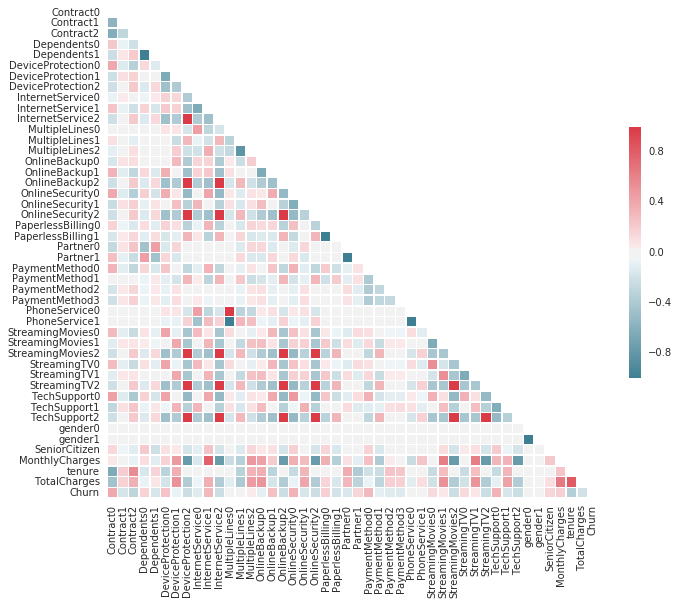

In [11]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Generate a large random dataset
d = churn_encoded_numeric

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

<h1><center>Principal Component Analysis To Analyze Bahavior</center></h1>

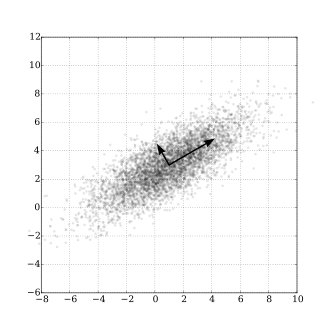

Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components. The number of principal components is less than or equal to the number of original variables.




In [12]:

from sklearn.decomposition import PCA
scaler = preprocessing.StandardScaler().fit(churn_encoded_numeric.drop('Churn', axis=1))
X_scaled = preprocessing.scale(churn_encoded_numeric, with_mean=True, with_std=True )   # same as (df-df.mean())/df.std(ddof=0)
# start w n_components principal components and see how much variance that gives me
n_components = 9
# create instance of PCA (constructor)
pca = PCA(n_components=n_components)
#pca = PCA(copy=True, iterated_power='auto', n_components=n_components, random_state=None, svd_solver='auto', tol=0.0, whiten=False) 
pca.fit(X_scaled)
X_scaled = pca.transform(X_scaled)  #get the actual principal components as vectors
print(pca.explained_variance_ratio_) 

[ 0.24846864  0.13513933  0.09331914  0.05528872  0.04969157  0.04352125
  0.03636349  0.0338883   0.02966935]


# Create copy the PCA data to a Dataframe and print the top few rows

In [13]:
Col_headings = ['P'+str(x) for x in range(n_components)]
pcomps = pd.DataFrame(X_scaled) 
pcomps.columns = Col_headings
# concatenate the Churn column on the end so its easy to plot by Churn
if 'Churn' not in pcomps.columns:
    pcomps = pd.concat([pcomps, label], axis=1)
pcomps.head()


,P0,P1,P2,P3,P4,P5,P6,P7,P8,Churn
0,-1.967118,-2.749776,4.724537,1.230065,2.763536,-1.718297,-2.108607,-0.807062,1.567418,0
1,-0.277880,-0.979293,2.011423,-1.211446,-3.505392,1.672151,1.097517,0.763494,1.043817,0
2,-1.030463,-3.040320,1.104327,-1.167844,-2.137236,1.265105,-0.664055,-2.155776,0.656320,1
3,-0.974244,0.248569,6.422879,1.966257,-1.618404,1.483498,-0.304206,1.010995,0.239675,0
4,-2.035808,-4.413641,-1.354042,-0.571185,-0.128554,-1.453505,0.123102,-0.664513,-0.227507,1


# PCA Scree Plot

### Overview

A Scree Plot is a simple line segment plot that shows the fraction of total variance in the data as explained or represented by each PC. The PCs are ordered, and by definition are therefore assigned a number label, by decreasing order of contribution to total variance. The PC with the largest fraction contribution is labeled with the label name from the preferences file. Such a plot when read left-to-right across the abscissa can often show a clear separation in fraction of total variance where the 'most important' components cease and the 'least important' components begin. The point of separation is often called the 'elbow'.  (In the PCA literature, the plot is called a 'Scree' Plot because it often looks like a 'scree' slope, where rocks have fallen down and accumulated on the side of a mountain.)

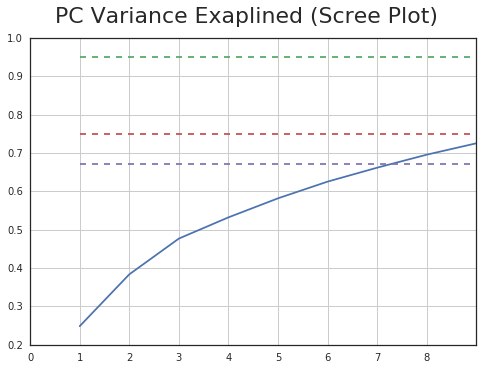

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# bin is my x axis variable
bin = []
for i in range (n_components):
    bin.append(i+1)
# plot the cummulative variance against the index of PCA
cum_var = np.cumsum(pca.explained_variance_ratio_)
plt.plot(bin, cum_var)
# plot the 95% threshold, so we can read off count of principal components that matter
plt.plot(bin, [.95]*n_components, '--')
plt.plot(bin, [.75]*n_components, '--')
plt.plot(bin, [.67]*n_components, '--')
#turn on grid to make graph reading easier
plt.grid(True)
plt.rcParams.update({'font.size': 22})
plt.suptitle('PC Variance Exaplined (Scree Plot)')
# control number of tick marks
plt.xticks([i for i in range(0,n_components)])
plt.show()

# Plot Principal Components: Scatter Matrix

Control the **colors** by the ** churn variable** or by the cluster they are in

Get a feel for clsutering beahvior

* **black = no churn**

* **red = churn**

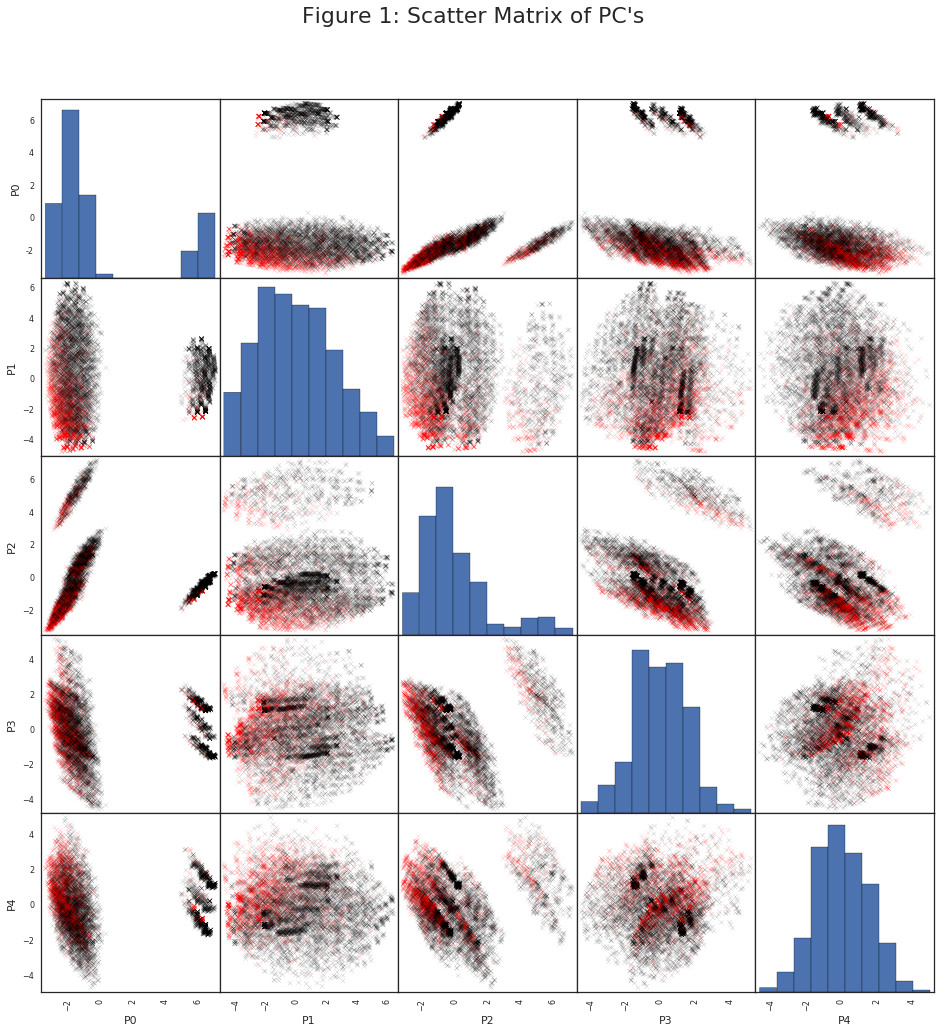

In [15]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas import scatter_matrix
import matplotlib.pyplot as plt
%matplotlib inline

# Figure 1
# color the plot by the Churn variable
# attributes are the index of Principal components to plot against each other
attributes = [0, 1, 2, 3, 4]
#attributes = [item + 10 for item in attributes]   # mthod to add if you want to look at the least significant components
churn_colors=['black', 'red']
# make a scatter plot
scatter_matrix(pcomps[attributes], alpha =.3, marker='x',c=pcomps.Churn.apply(lambda x:churn_colors[x]), figsize=[16,16])
#scatter_matrix(pcomps[attributes], alpha =.3, marker='x',c=churn_cat_encode_new2.InternetService0.astype('int').apply(lambda x:churn_colors[x]), figsize=[16,16])
plt.rcParams.update({'font.size': 22})
plt.suptitle("Figure 1: Scatter Matrix of PC's")
plt.show()


## Method to Drill Down to Specific Portion of the Data
We are keying off the graph above and noticing that P0 < 0 covers a major portionof the clusters

So what makes this part of the tick?

In [16]:
churn_encoded_numeric[pcomps['P0']>0].describe()

,Contract0,Contract1,Contract2,Dependents0,Dependents1,DeviceProtection0,DeviceProtection1,DeviceProtection2,InternetService0,InternetService1,...,TechSupport0,TechSupport1,TechSupport2,gender0,gender1,SeniorCitizen,MonthlyCharges,tenure,TotalCharges,Churn
count,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537,...,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000,1537.000000
mean,0.340924,0.240729,0.418347,0.574496,0.425504,0.003253,0.003904,0.992843,0.007157,0,...,0.002602,0.004554,0.992843,0.488614,0.511386,0.033832,21.362850,30.576448,682.036729,0.073520
std,0.474174,0.427665,0.493448,0.494580,0.494580,0.056962,0.062378,0.084322,0.084322,0,...,0.050965,0.067354,0.084322,0.500033,0.500033,0.180856,4.016227,24.333368,584.748366,0.261073
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,0.000000,18.800000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,19.700000,8.000000,161.950000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0,...,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,20.150000,25.000000,531.600000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0,...,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,20.950000,53.000000,1124.200000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,73.600000,72.000000,4097.050000,1.000000



# Find KMeans Clusters in the PCA Data

Lets use an algorithm to groups clusters it finds together. We will label our data with the clusters we find so we can sort and filter as needed

Here we use kmeans as a quick and dirty clustering method to get a better feel for customer behavior

Ideally I would like to identify a cluster for each natural cluster of customer bevaior

Armed with this I may decide to sgement out interesting populations for prediction, or I may decide that one big prediction against all the data is best

We will augment the rows of the dataset with the cluster information so that it can be used in our models

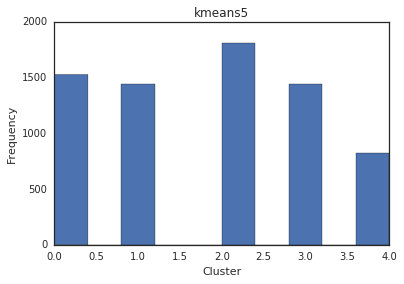

In [17]:
from sklearn.cluster import KMeans
import numpy as np

def my_kmeans(pcomps, n_clusters):
    x = pcomps[[0,1,2]].as_matrix()
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(x)
    kmeans.labels_
    X_scaled.shape
    #kmeans.cluster_centers_
    txt = 'kmeans' + str(n_clusters)
    pcomps[txt]=kmeans.labels_
    return pcomps

pcomps = my_kmeans(pcomps,2)
pcomps = my_kmeans(pcomps,3)
pcomps = my_kmeans(pcomps,4)
pcomps = my_kmeans(pcomps,5)

plt.hist( pcomps['kmeans5'])
plt.title("kmeans5")
plt.xlabel("Cluster")
plt.ylabel("Frequency")

plt.show()
#churn_cat_encode_new2[df['kmeans']==1].describe()

In [18]:
churn_scaled = pd.concat([churn_scaled, pcomps['kmeans2']], axis=1)
churn_scaled = pd.concat([churn_scaled, pcomps['kmeans3']], axis=1)
churn_scaled = pd.concat([churn_scaled, pcomps['kmeans4']], axis=1)
churn_scaled = pd.concat([churn_scaled, pcomps['kmeans5']], axis=1)
churn_encoded_numeric = pd.concat([churn_encoded_numeric, pcomps['kmeans2']], axis=1)
churn_encoded_numeric = pd.concat([churn_encoded_numeric, pcomps['kmeans3']], axis=1)
churn_encoded_numeric = pd.concat([churn_encoded_numeric, pcomps['kmeans4']], axis=1)
churn_encoded_numeric = pd.concat([churn_encoded_numeric, pcomps['kmeans5']], axis=1)


# Examine Specific Cluster Like This

In [19]:
churn_encoded_numeric[pcomps['kmeans5']==1].head()

,Contract0,Contract1,Contract2,Dependents0,Dependents1,DeviceProtection0,DeviceProtection1,DeviceProtection2,InternetService0,InternetService1,...,gender1,SeniorCitizen,MonthlyCharges,tenure,TotalCharges,Churn,kmeans2,kmeans3,kmeans4,kmeans5
5,1,0,0,1,0,0,1,0,0,1,...,0,0,99.65,8,820.50,1,1,2,3,1
6,1,0,0,0,1,1,0,0,0,1,...,1,0,89.10,22,1949.40,0,1,2,3,1
8,1,0,0,1,0,0,1,0,0,1,...,0,0,104.80,28,3046.05,1,1,0,1,1
13,1,0,0,1,0,0,1,0,0,1,...,1,0,103.70,49,5036.30,1,1,0,1,1
14,1,0,0,1,0,0,1,0,0,1,...,1,0,105.50,25,2686.05,0,1,0,1,1


# Experiment with 3D plot: Red = Churn
This may give a better feel for the clustering behavior

Control the colors as you wish, here we color Churners red
**red = Churn**

The plot should be interactive so you can rotate it a see where churners live

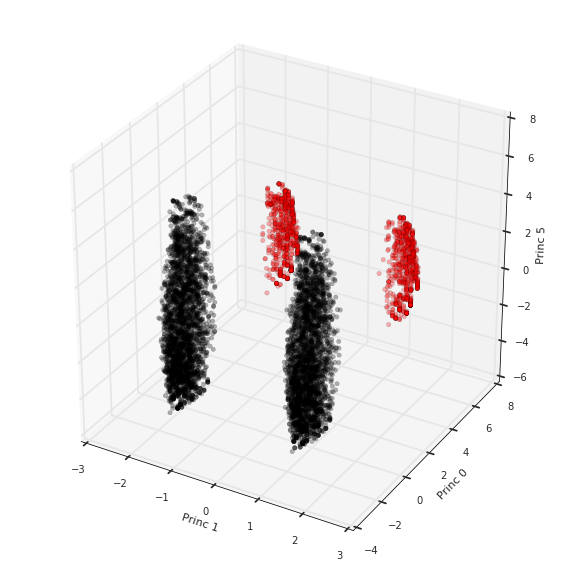

In [20]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection='3d')
colors=['black','red']
#df = pcomps[pcomps['kmeans3']==2]
df = pcomps
churn_colors=['red' , 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black', 'black']
ax.scatter(df['P5'], df['P0'], df['P1'],c=df['kmeans5'].apply(lambda x:churn_colors[x]), alpha = .3 )

ax.set_xlabel('Princ 1')
ax.set_ylabel('Princ 0')
ax.set_zlabel('Princ 5')

plt.show()




# One Approach to Outliers (DBSCAN Visualization)

Control the **colors** by the **cluster** they are in

Get a feel for clsutering behavior

We added the cluster number to the dataframe so we can drill down as needed to examine a cluster in more detail.

When we create the model we might decide to take advantage of our feature engineering here or we might decide to let the ML/DL algorithm use all the data to make predictions.

**NOTE:** Be careful with relying on the cluster number. These were established by random selection. So each time we run we may get a different cluster number for what humans percieve as a clsuter or the k-means may find different clusters entirely. Specifying a random seed or using a different cluster methods, such SOM may make this part more rubust.

It would be great if we coudl isolate the different communities from each other and see if this effects the chrun prediction

eps:4 Estimated number of clusters: 1
Outliers: 105:   Estimated number of clusters: 1


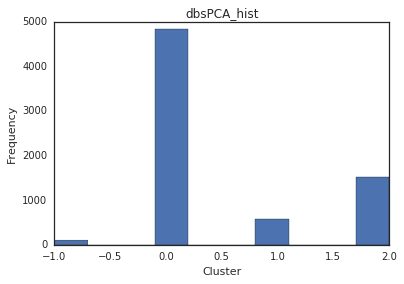

In [21]:
### import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
# X = pcomps.iloc[[1, 3, 5], [1, 3]]
X = pcomps
np.random.seed(42)

pcomps2, labels, n_clusters = my_dbscan(X,  4)  # call my_dbscan with df=X, eps = 4

dbsPCA_hist = pcomps2.dbsPCA
print('Outliers: {}:   Estimated number of clusters: {}'.format(  dbsPCA_hist.tolist().count(-1),  n_clusters) )
plt.hist( dbsPCA_hist)
plt.title("dbsPCA_hist")
plt.xlabel("Cluster")
plt.ylabel("Frequency")
#plt.axis([-1,n_clusters,0,7200])
plt.show()

In [22]:
churn_encoded_numeric = pd.concat([churn_encoded_numeric, pcomps['dbsPCA']], axis=1)


In [23]:
churn_encoded_numeric.head()

,Contract0,Contract1,Contract2,Dependents0,Dependents1,DeviceProtection0,DeviceProtection1,DeviceProtection2,InternetService0,InternetService1,...,SeniorCitizen,MonthlyCharges,tenure,TotalCharges,Churn,kmeans2,kmeans3,kmeans4,kmeans5,dbsPCA
0,1,0,0,1,0,1,0,0,1,0,...,0,29.85,1,29.85,0,1,2,0,4,1
1,0,1,0,1,0,0,1,0,1,0,...,0,56.95,34,1889.50,0,1,2,0,4,0
2,1,0,0,1,0,1,0,0,1,0,...,0,53.85,2,108.15,1,1,2,3,2,0
3,0,1,0,1,0,0,1,0,1,0,...,0,42.30,45,1840.75,0,1,0,0,4,1
4,1,0,0,1,0,1,0,0,0,1,...,0,70.70,2,151.65,1,1,2,3,2,0


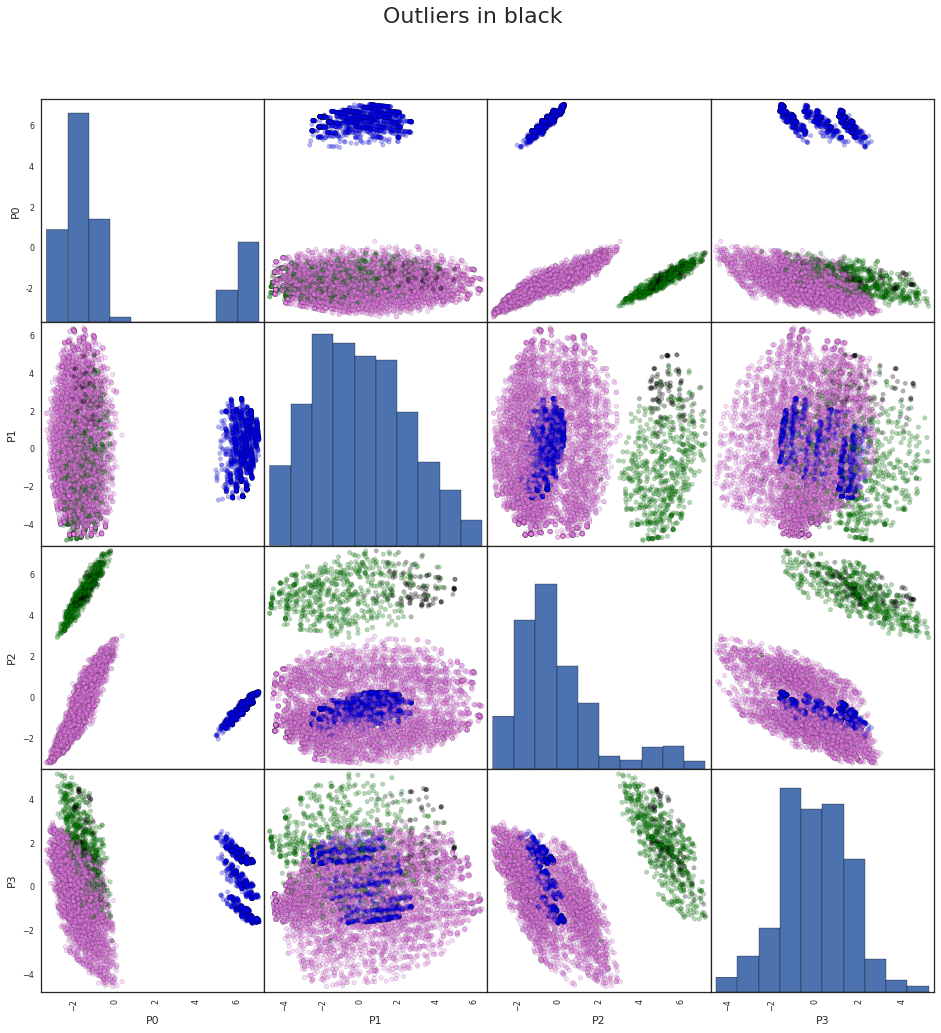

In [24]:
# Figure 2
# plot each cluster a different color so we can see what cluster number is associated with each blob
df2 = pcomps
#df2 = pcomps[pcomps['Churn'] == 1]
# make a scatter plot
#attributes = [0, 1, 2]
#colors=['blue','green','yellow']

attributes = [0, 1, 2, 3]
colors=['black', 'violet','green','blue', 'yellow', 'red', 'gray', 'white', 'orange']
scatter_matrix(df2[attributes],figsize=[16,16],marker='o', alpha=.3, c=df2['dbsPCA'].apply(lambda x:colors[x+1]))
plt.rcParams.update({'font.size': 22})
plt.suptitle("Outliers in black")
plt.show()

In [25]:
print('Outliers: {} '.format(  dbsPCA_hist.tolist().count(-1)) )
churn_encoded_numeric[churn_encoded_numeric['dbsPCA']<0].describe()

Outliers: 105 


,Contract0,Contract1,Contract2,Dependents0,Dependents1,DeviceProtection0,DeviceProtection1,DeviceProtection2,InternetService0,InternetService1,...,SeniorCitizen,MonthlyCharges,tenure,TotalCharges,Churn,kmeans2,kmeans3,kmeans4,kmeans5,dbsPCA
count,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105,105,105,...,105.000000,105.000000,105.000000,105.000000,105.000000,105,105.000000,105,105.000000,105
mean,0.028571,0.209524,0.761905,0.419048,0.580952,0.104762,0.895238,0,1,0,...,0.085714,56.212381,58.219048,3318.146667,0.019048,1,0.019048,0,3.990476,-1
std,0.167398,0.408921,0.427960,0.495770,0.495770,0.307715,0.307715,0,0,0,...,0.281284,7.510767,17.252637,1135.686833,0.137348,0,0.195180,0,0.097590,0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,...,0.000000,38.500000,7.000000,305.550000,0.000000,1,0.000000,0,3.000000,-1
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0,1,0,...,0.000000,51.200000,47.000000,2640.550000,0.000000,1,0.000000,0,4.000000,-1
50%,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0,1,0,...,0.000000,57.600000,66.000000,3527.000000,0.000000,1,0.000000,0,4.000000,-1
75%,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0,1,0,...,0.000000,61.400000,72.000000,4193.400000,0.000000,1,0.000000,0,4.000000,-1
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0,1,0,...,1.000000,67.200000,72.000000,4919.700000,1.000000,1,2.000000,0,4.000000,-1


# Examine Outliers Statistics Like This

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe9e8a70450>]], dtype=object)

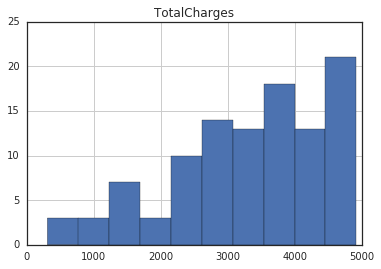

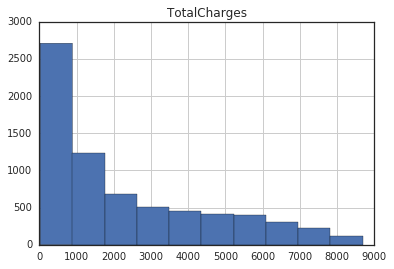

In [26]:
#churn_encoded_numeric[pcomps['dbsPCA']<0].head()
if 'Churn' not in churn_encoded_numeric.columns:
    churn_encoded_numeric = pd.concat([churn_encoded_numeric, label], axis=1)  # add numeric to main df
churn_encoded_numeric[pcomps['dbsPCA']<0]

TotalC = churn_encoded_numeric[pcomps['dbsPCA']<0][['TotalCharges','Churn']]
#plt.title('Total Charges: Histogram for Outliers')
TotalC.hist(column = 'TotalCharges')
#plt.title('Total Charges: Histogram for All Records')
churn_encoded_numeric.hist(column = 'TotalCharges')

In [27]:
churn_encoded_numeric[pcomps['dbsPCA']<0].describe()

,Contract0,Contract1,Contract2,Dependents0,Dependents1,DeviceProtection0,DeviceProtection1,DeviceProtection2,InternetService0,InternetService1,...,SeniorCitizen,MonthlyCharges,tenure,TotalCharges,Churn,kmeans2,kmeans3,kmeans4,kmeans5,dbsPCA
count,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105,105,105,...,105.000000,105.000000,105.000000,105.000000,105.000000,105,105.000000,105,105.000000,105
mean,0.028571,0.209524,0.761905,0.419048,0.580952,0.104762,0.895238,0,1,0,...,0.085714,56.212381,58.219048,3318.146667,0.019048,1,0.019048,0,3.990476,-1
std,0.167398,0.408921,0.427960,0.495770,0.495770,0.307715,0.307715,0,0,0,...,0.281284,7.510767,17.252637,1135.686833,0.137348,0,0.195180,0,0.097590,0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,...,0.000000,38.500000,7.000000,305.550000,0.000000,1,0.000000,0,3.000000,-1
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0,1,0,...,0.000000,51.200000,47.000000,2640.550000,0.000000,1,0.000000,0,4.000000,-1
50%,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0,1,0,...,0.000000,57.600000,66.000000,3527.000000,0.000000,1,0.000000,0,4.000000,-1
75%,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0,1,0,...,0.000000,61.400000,72.000000,4193.400000,0.000000,1,0.000000,0,4.000000,-1
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0,1,0,...,1.000000,67.200000,72.000000,4919.700000,1.000000,1,2.000000,0,4.000000,-1


In [28]:
churn_encoded_numeric.describe()

,Contract0,Contract1,Contract2,Dependents0,Dependents1,DeviceProtection0,DeviceProtection1,DeviceProtection2,InternetService0,InternetService1,...,SeniorCitizen,MonthlyCharges,tenure,TotalCharges,Churn,kmeans2,kmeans3,kmeans4,kmeans5,dbsPCA
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,...,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.550192,0.209144,0.240664,0.700412,0.299588,0.439443,0.343888,0.216669,0.343746,0.439585,...,0.162147,64.761692,32.371149,2283.300441,0.265370,0.783331,1.104927,1.845520,1.800937,0.500497
std,0.497510,0.406726,0.427517,0.458110,0.458110,0.496355,0.475038,0.412004,0.474991,0.496372,...,0.368612,30.090047,24.559481,2265.000258,0.441561,0.412004,0.878881,1.054866,1.306099,0.844545
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,18.250000,0.000000,18.800000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,35.500000,9.000000,402.225000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
50%,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,70.350000,29.000000,1400.550000,0.000000,1.000000,1.000000,2.000000,2.000000,0.000000
75%,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,...,0.000000,89.850000,55.000000,3786.600000,1.000000,1.000000,2.000000,3.000000,3.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,118.750000,72.000000,8684.800000,1.000000,1.000000,2.000000,3.000000,4.000000,2.000000


# Modeling

## Split Data - Training/Test

Splitting the data can be a very easy thing but its also easy to get into trouble.

We want to ensure that in subsequent runs we never contaminate the test set from run to run. Using a random seed help something like randseed = 42

But if we ever drop or add rows, and then use the same random selection we will likely wind up putting a new value into our test set inadvertantly.

It would be best to split the data based on some invariant such as a hask of column names or some other unique row identifier. But for now we take the easy random split approach.

In [29]:
# to make this notebook's output identical at every run
np.random.seed(42)
# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

churn_encoded_numeric
churn_scaled = pd.concat([churn_cat['customerID'], churn_encoded_numeric], axis=1)
churn_scaled.head()
if ( len(churn_scaled.customerID.unique()) ==  len(churn_encoded_numeric)) : print "Unique Identifier"

train_set, test_set = split_train_test(churn_scaled, 0.2)


Unique Identifier


# First Model - Decision Tree

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

X = churn_scaled.drop(u'customerID', axis=1)

clf = DecisionTreeClassifier(random_state=0)
AllCols = X.columns
StaticCols = ['Churn']

dataCols = sorted(list(set(AllCols) - set(StaticCols)))
clf.fit(train_set[dataCols], train_set['Churn'])
#accuracy = cross_val_score(clf, churn_cat_encode_new2[dataCols], churn_cat_encode_new2['Churn'], cv=10)
predicted = clf.predict(test_set[dataCols])
print accuracy_score(test_set['Churn'], predicted )

0.727982954545


# Second Model - Decision Tree on PCA

Ok - this one works even better.  Read up on the advantages and disadvantages of PCA as part of a data pipleine and see if it suitable for your application.  There is no magical single method, everyhting has trade offs, but hopefully you have more information to go off and explore.

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

X = churn_encoded_numeric
clf = DecisionTreeClassifier(random_state=0)
AllCols = X.columns
StaticCols = ['Churn']

dataCols = sorted(list(set(AllCols) - set(StaticCols)))
accuracy = cross_val_score(clf, X[dataCols], X['Churn'], cv=10)
accuracy.mean()

0.73619267854080284